# **CS5658 Anomaly Detection Homework3 – Industrial Anomaly Detection**

## Due Date:  5/2 23:30

#### MVTec AD dataset
MVTec AD is a benchmark dataset for industrial anomaly detection tasks. It contains 15 industrial product classes with over 5000 images in total. The dataset is designed to perform image anomaly detection and segmentation tasks. There are normal / defect images for each class, with ground truth masks provided for the defect samples.


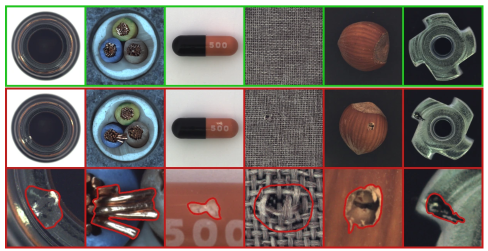

### SimpleNet
SimpleNet is a deep learning model proposed in CVPR 2023. It trains a simple MLP by classifying noisy features from normal features and using it as a discriminator to classify whether a feature is anomaly or not.

Reference: SimpleNet, CVPR 2023

Paper: https://openaccess.thecvf.com/content/CVPR2023/papers/Liu_SimpleNet_A_Simple_Network_for_Image_Anomaly_Detection_and_Localization_CVPR_2023_paper.pdf

Github: https://github.com/DonaldRR/SimpleNet

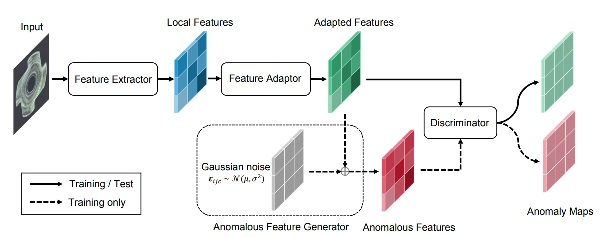


# Problem Setting
In this homework, we will choose two classes in MVTecAD: `metal_nut` and `leather` to perform anomaly detection and segmentation task. You need to implement SimpleNet method by your own, then inference on the two classes. We will use SimpleNet as our architecture, but for the simplicity and training speed, we've made a little adjustments.

* Ignore average pooling in constructing multi-scale feature map
* Use layers [2,3] of WideResNet50
* Epoch reduced from 40 to 20
* Ignore learning rate scheduler
* Discriminator outputs anomaly score instead of normal score

Please implement adaptor and discriminator using the assigned learning rate as follow.
```
adaptor_lr = 1e-3
discriminator_lr = 2e-4
```

Please use **pretrained WideResNet 50** as your feature extractor.

# 1.Download Dataset

In [1]:
# !gdown 1vFb_AWIK6nh8BRhRQLM96q2nUqPHsdAR
# !unzip mvtec.zip

# 2.Prepare Environment

1.Install needed modules

In [2]:
# !pip install einops

2.Import needed modules and set random seed to ensure that results
are consistent every time executed.

In [1]:
from torchvision.models import wide_resnet50_2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import numpy as np
import random
from PIL import Image
import torch
import torch.nn as nn
from einops import rearrange
from tqdm import tqdm
import os
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt


#########################################
# prepare environment
def seed_everything(seed):
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

seed_everything(9999)

# 3.Prepare Dataset

In [2]:
#######################################
# prepare dataset
class MVTecDataset(Dataset):
    def __init__(self, mvtec_folder_path='./mvtec', class_name='leather', is_train=True,
                 few_shot=16,resize=256):
        self.class_name = class_name
        self.is_train = is_train
        self.resize = resize
        self.mvtec_folder_path = mvtec_folder_path
        self.few_shot = few_shot
        # set transforms
        self.transform_x = T.Compose([T.Resize(resize,interpolation=T.InterpolationMode.BILINEAR),
                                      T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])])
        self.transform_mask = T.Compose([T.Resize(resize, interpolation=T.InterpolationMode.NEAREST),
                                         T.ToTensor()])
        # load dataset
        self.x, self.y, self.mask = self.load_dataset_folder()
        phase = 'training' if self.is_train else 'testing'
        print(f"{self.class_name} {phase} dataset created, consists of {len(self.x)} images")


    def __getitem__(self, idx):
        x, y, mask = self.x[idx], self.y[idx], self.mask[idx]
        return x, y, mask

    def __len__(self):
        return len(self.x)

    def load_dataset_folder(self):
        phase = 'train' if self.is_train else 'test'
        x, y, mask = [], [], []
        img_dir = os.path.join(self.mvtec_folder_path, self.class_name, phase)
        gt_dir = os.path.join(self.mvtec_folder_path, self.class_name, 'ground_truth')
        img_types = sorted(os.listdir(img_dir))
        for img_type in img_types:
            # load images
            img_type_dir = os.path.join(img_dir, img_type)
            if not os.path.isdir(img_type_dir):
                continue
            img_fpath_list = sorted([os.path.join(img_type_dir, f)
                                     for f in os.listdir(img_type_dir)
                                     if f.endswith('.png')])
            x.extend(img_fpath_list)
            # load gt labels
            if img_type == 'good':
                y.extend([0] * len(img_fpath_list))
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))
                gt_type_dir = os.path.join(gt_dir, img_type)
                img_fname_list = [os.path.splitext(os.path.basename(f))[0] for f in img_fpath_list]
                gt_fpath_list = [os.path.join(gt_type_dir, img_fname + '_mask.png')
                                 for img_fname in img_fname_list]
                mask.extend(gt_fpath_list)

        assert len(x) == len(y), 'number of x and y should be same'

        if self.few_shot is not None and phase=='train':
            # pick images according to few_shot number
            chosen_idx = random.sample(list(range(len(x))),k=self.few_shot)
            x = [x[i] for i in chosen_idx]
            y = [y[i] for i in chosen_idx]
            mask = [mask[i] for i in chosen_idx]

        return [self.transform_x(Image.open(x).convert('RGB')).cuda() for x in list(x)], \
                list(y), \
                [torch.zeros([1, self.resize, self.resize]).cuda() if y==0 else self.transform_mask(Image.open(mask)).cuda() for y,mask in zip(list(y),list(mask))]


# 4.Load & Prepare Feature Extractor

In [3]:

#######################################
# load & prepare model (wide_resnet50_2)
encoder = wide_resnet50_2(pretrained=True, progress=True).cuda()
encoder.eval()
# set hook function to get features
outputs = list()
def hook(module, input, output):
    outputs.append(output)

def get_features(model,img,outputs):
    with torch.no_grad():
            _ = model(img.cuda())
    layer1_feature = outputs[0]
    layer2_feature = outputs[1]
    layer3_feature = outputs[2]
    outputs.clear()
    return [layer1_feature,layer2_feature,layer3_feature]

encoder.layer1.register_forward_hook(hook)
encoder.layer2.register_forward_hook(hook)
encoder.layer3.register_forward_hook(hook)

c:\Users\user\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 5.Define Our Function to Produce Multi-Scale Feature Map (TODO Q1)

## TODO Q1
In this section, you need to produce multi-scale feature map in this function.</br></br>
The procedure is listed below:</br>
1. Choose a size to resize to, for example, size of second layers as our target size.</br>
1. Resize all features to the target size and store them.</br>
1. Concatenate them all together and return the result.</br>

You need to finish the step2 above, that is, resize `features[i]` to the target size and assign to `temp_feature`.</br>
For example, if the `target_size` is 32, and `features[i]` have size `(batch, channel, width, height)`, the `temp_feature` should have size `(batch, channel, 32, 32)`




In [4]:
import torch.nn.functional as F
#######################################
# produce multi-scale feature
def concat_feature(features,use_layers=None):
    use_layers = [i-1 for i in use_layers]
    # determine resize to which feature
    target_size = features[1].size()[3] # 32
    resized_feature = list()

    for i in range(len(features)):
        current_size = features[i].size()[3]

        ## TODO ######################################################
        # please calculate the factor or size to resize to
        # use F.interpolate() to resize, set mode to bilinear
        # align_corners to False.
        # For more instruction, please refer to :
        # https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html

        scale_factor = target_size / current_size
        temp_feature = F.interpolate(features[i], scale_factor=scale_factor, mode='bilinear', align_corners=False)
        resized_feature.append(temp_feature)
        
        #############################################################

    return torch.concat([resized_feature[i] for i in use_layers],dim=1)

# 6.Define The Adaptor & Discriminator Of Our Model (TODO Q2)

## TODO Q2
- In this section, you need to design a MLP as the Adaptor.</br>
- The MLP should takes in a tensor with `in_channel` as its channel dimention, and outputs a tensor with `out_channel` as its channel dimention.</br>
- First, implement **the same Adaptor** in SimpleNet paper.
- Second, design your own version of Adaptor with **fewer model parameters to approach the SimpleNet performance**. You need to try **TWO** kinds of model settings. </br>
NOTE: the MLP should not be very complex, you can design a simple one, check the result, and determine if it needs to be more complex. </br></br>

---


**HINT:** A good design should result in Image-AUC=0.95 for leather, Image-AUC=0.95 for metal_nut in Sec.13. your image-AUC of both classes must be greater than 0.8.</br>
***layers = Linear -> LeakyReLU(0.2)***</br>
Things you can change: number of layers, activation function, number of hidden dimension, add Dropout layer, etc. </br>

In [5]:
# Implement the same Adaptor in SimpleNet
class Adaptor(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Adaptor, self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.linear = nn.Linear(self.in_channel, self.out_channel)
        self.leaky_relu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = rearrange(x, 'b c h w -> (b h w) c')
        x = self.linear(x)
        x = self.leaky_relu(x)
        
        return x

- In this section, you need to design a MLP as the Discriminator's body.</br>
- The MLP should takes in a tensor with `in_channel` as its channel dimention, and outputs a tensor with `mid_channel` as its channel dimention.</br>
- First, implement **the same Discriminator** in SimpleNet paper.
- Second, design your own version of Discriminator with **fewer model parameters to approach the SimpleNet performance**. You need to try **TWO** kinds of model settings. </br>
NOTE: the Discriminator should involve at least one BatchNormalization layer.</br></br>

---


**HINT:** A good design should result in Image-AUC=0.95 for leather, Image-AUC=0.95 for metal_nut in Sec.13. It's OK to get lower score than default, but image-AUC of both classes must be greater than 0.8.</br>
***Body = Linear -> BatchNorm1d -> LeakyReLU(0.2)***</br>
Things you can change: number of layers, activation function, number of hidden dimension (`mid_channel`), add Dropout layer, etc. </br>


In [6]:
# Implement the same Discriminator in SimpleNet
class Discriminator(nn.Module):
    def __init__(self, in_channel):
        super(Discriminator, self).__init__()
        self.in_channel = in_channel
        # mid_c = [32, 16] # 1024?
        self.body = nn.Sequential()
        mid_c = self.in_channel
        for i in range(2):
            in_c = in_channel if i == 0 else mid_c
            mid_c = int(mid_c // 1.5)
            self.body.add_module(
                name="Block%d" % (i + 1),
                module=nn.Sequential(
                    nn.Linear(in_c, mid_c), 
                    nn.BatchNorm1d(mid_c), 
                    nn.LeakyReLU(0.2)
                ),
            )
        self.tail = nn.Linear(mid_c, 1, bias=False)
    
    def forward(self, x):
        x = self.body(x)
        x = self.tail(x)
        
        return x

# Implement your own Discriminator with fewer model parameters
class Discriminator_1(nn.Module):
    def __init__(self, in_channel):
        super(Discriminator_1, self).__init__()
        self.in_channel = in_channel
        self.mid_channel = 1024
        self.body = nn.Sequential(
            nn.Linear(self.in_channel, self.mid_channel), 
            nn.BatchNorm1d(self.mid_channel), 
            nn.LeakyReLU(0.2)
        )
        self.tail = nn.Linear(self.mid_channel, 1, bias=False)
    
    def forward(self, x):
        x = self.body(x)
        x = self.tail(x)
        
        return x

class Discriminator_2(nn.Module):
    def __init__(self, in_channel):
        super(Discriminator_2, self).__init__()
        self.in_channel = in_channel
        self.mid_channel = 512
        self.body = nn.Sequential(
            nn.Linear(self.in_channel, self.mid_channel), 
            nn.BatchNorm1d(self.mid_channel), 
            nn.GELU()
        )
        self.tail = nn.Sequential(
            nn.Linear(self.mid_channel, 1, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.body(x)
        x = self.tail(x)
        
        return x

# 7.Define Our Whole Model (SimpleNet)

In [7]:
#######################################
# define our model (simplenet)
class Simplenet(nn.Module):
    def __init__(self,in_channel, model_type=0):
        super(Simplenet,self).__init__()
        self.adaptor = Adaptor(in_channel,in_channel)
        if(model_type == 0):
            self.discriminator = Discriminator(in_channel)
        elif(model_type == 1):
            self.discriminator = Discriminator_1(in_channel)
        elif(model_type == 2):
            self.discriminator = Discriminator_2(in_channel)

    def add_noise(self,true_feats):
        noise_idxs = torch.randint(0, 1, torch.Size([true_feats.shape[0]]))
        noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=1).cuda() # (N, K)
        noise = torch.stack([
            torch.normal(0, 0.05 * 1.1**(k), true_feats.shape)
            for k in range(1)], dim=1).cuda() # (N, K, C)
        noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
        return true_feats + noise

    def forward(self,x):
        true_feats = self.adaptor(x)
        fake_feats = self.add_noise(true_feats)
        scores = self.discriminator(torch.cat([true_feats,fake_feats],dim=0))
        return scores

    def predict(self,x):
        true_feats = self.adaptor(x)
        scores = self.discriminator(true_feats)
        return scores,true_feats

# 8.Define The Training Process

In [8]:
def train_one_epoch(encoder,simplenet,adaptor_optim,discriminator_optim,dataset,use_layers,batch_size):
    total_loss = 0
    for x,y,mask in DataLoader(dataset,batch_size=batch_size):
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,use_layers)
        scores = simplenet(features)
        true_scores = scores[:features.size()[0]*features.size()[2]*features.size()[3]]
        fake_scores = scores[features.size()[0]*features.size()[2]*features.size()[3]:]

        th = 0.5 # margin
        true_loss = torch.clip(true_scores + th, min=0)
        fake_loss = torch.clip(-fake_scores + th, min=0)

        loss = true_loss.mean() + fake_loss.mean()
        total_loss += loss

        # clear gradient
        adaptor_optim.zero_grad()
        discriminator_optim.zero_grad()

        # calculate new gradient
        loss.backward()

        # update parameters
        adaptor_optim.step()
        discriminator_optim.step()
    return total_loss

# 9.Define The Testing Process

In [9]:
#######################################
# testing
@torch.no_grad()
def test(encoder,simplenet,dataset,use_layers,batch_size):
    result = dict()
    result['total_scores_pixel'] = list()
    result['total_scores_image'] = list()
    result['total_gt_pixel'] = list()
    result['total_gt_image'] = list()
    result['features_orig'] = list()
    result['features_adapted'] = list()
    result['input_image'] = list()


    for x,y,mask in DataLoader(dataset,batch_size=batch_size):
        simplenet.eval()
        # store input image
        result['input_image'].append(x.cpu().detach().numpy())
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,use_layers)
        # store features before adaptor
        result['features_orig'].append(rearrange(features,'b c h w -> (b h w) c').cpu().detach().numpy())
        size = features.size()
        scores,true_feats = simplenet.predict(features)
        # store features after adaptor
        result['features_adapted'].append(true_feats.cpu().detach().numpy())

        # calculate and store image-level anomaly score
        anomaly_score_map = rearrange(scores,'(b h w) 1 -> b (h w)',b=size[0],h=size[3],w=size[2])
        image_score,_ = torch.max(anomaly_score_map,dim=1,keepdim=False)
        result['total_scores_image'].append(image_score.cpu().detach().numpy())

        # calculate and store pixel-level anomaly score
        anomaly_score_map = rearrange(scores,'(b h w) 1 -> b 1 h w',b=size[0],h=size[3],w=size[2])
        anomaly_score_map = F.interpolate(anomaly_score_map,
                                        size=(x.size()[2],x.size()[3]),
                                        mode="bilinear",
                                        align_corners=False)
        anomaly_score_1d = rearrange(anomaly_score_map,'b c h w -> (b c h w)')
        result['total_scores_pixel'].append(anomaly_score_1d.cpu().detach().numpy())

        # store groundtruth
        mask_1d = rearrange(mask,'b c h w -> (b c h w)')
        result['total_gt_pixel'].append(mask_1d.cpu().detach().numpy())
        result['total_gt_image'].append(y.cpu().detach().numpy())

    # gether all scores and groundtruth
    result['input_image'] = np.concatenate(result['input_image'],axis=0)
    result['total_scores_pixel'] = np.hstack(result['total_scores_pixel'])
    result['total_scores_image'] = np.hstack(result['total_scores_image'])
    result['total_gt_pixel'] = np.hstack(result['total_gt_pixel'])
    result['total_gt_image'] = np.hstack(result['total_gt_image'])

    # gether all extracted features
    result['features_orig'] = np.concatenate(result['features_orig'],axis=0)
    result['features_adapted'] = np.concatenate(result['features_adapted'],axis=0)

    # min-max normalization on scores
    result['total_scores_pixel'] = minmax_scale(result['total_scores_pixel'])
    result['total_scores_image'] = minmax_scale(result['total_scores_image'])

    simplenet.train()
    return result

# 10.Define Functions That Calculate And Show ROC & AUROC (TODO Q3)

## TODO Q3
In this section, you need to define the function to calculate false-positive rate, true-positive rate and area-under ROC by the scores and the groundtruth labels and assign them to `fpr`, `tpr`, `auc` respectively.

In [10]:
def compute_roc_auc(y_label, scores):
    fpr, tpr, _ = roc_curve(y_label, scores)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc

# 11.Define Other Utility Functions (if Needed)

In [11]:
def plot_roc_auc(fpr, tpr, roc_auc, class_name):
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{class_name} ROC-AUC')
    plt.legend(loc="lower right")
    plt.show()

# 12.Setup Training Parameters

Setup learning rate, total epoch, layers to used, SimpleNet and optimizer for both class.

In [12]:
# Create datasets for both classes
dataset_train_metal = MVTecDataset(class_name="metal_nut", is_train=True, few_shot=32)
dataset_train_leather = MVTecDataset(class_name="leather", is_train=True, few_shot=32)
dataset_test_metal = MVTecDataset(class_name="metal_nut", is_train=False)
dataset_test_leather = MVTecDataset(class_name="leather", is_train=False)

metal_nut training dataset created, consists of 32 images
leather training dataset created, consists of 32 images
metal_nut testing dataset created, consists of 115 images
leather testing dataset created, consists of 124 images


In [13]:
# Training parameters
adaptor_lr = 1e-4
discriminator_lr = 2e-5
epochs = 20
batch_size = 16

# Define use_layers
use_layers = [2, 3]

In [14]:
# Create SimpleNet and optimizer for both classes
simplenet_metal_origin = Simplenet(in_channel=1536, model_type=0).cuda()
opt_adaptor_metal_origin = torch.optim.AdamW(simplenet_metal_origin.adaptor.parameters(), lr=adaptor_lr)
opt_discriminator_metal_origin = torch.optim.Adam(simplenet_metal_origin.discriminator.parameters(), lr=discriminator_lr, weight_decay=1e-5)

simplenet_leather_origin = Simplenet(in_channel=1536, model_type=0).cuda()
opt_adaptor_leather_origin = torch.optim.AdamW(simplenet_leather_origin.adaptor.parameters(), lr=adaptor_lr)
opt_discriminator_leather_origin = torch.optim.Adam(simplenet_leather_origin.discriminator.parameters(), lr=discriminator_lr, weight_decay=1e-5)

# 13.Start Training & Testing (TODO Q4)

## TODO Q4
Write your training / testing code and plot ROC curve.

In [15]:
# Training
loss_metal_list = []
loss_leather_list = []
for epoch in tqdm(range(epochs)):
    loss_metal = train_one_epoch(encoder, simplenet_metal_origin, opt_adaptor_metal_origin, opt_discriminator_metal_origin, dataset_train_metal, use_layers, batch_size)
    loss_leather = train_one_epoch(encoder, simplenet_leather_origin, opt_adaptor_leather_origin, opt_discriminator_leather_origin, dataset_train_leather, use_layers, batch_size)
    print(f"Epoch {epoch + 1}")
    print(f"Metal loss: {loss_metal}")
    print(f"Leather loss: {loss_leather}\n")
    loss_metal_list.append(loss_metal)
    loss_leather_list.append(loss_leather)

  0%|          | 0/20 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\torch_gpu\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
  5%|▌         | 1/20 [00:02<00:54,  2.87s/it]

Epoch 1
Metal loss: 1.7449862957000732
Leather loss: 1.956795334815979



 10%|█         | 2/20 [00:04<00:39,  2.18s/it]

Epoch 2
Metal loss: 1.118703007698059
Leather loss: 1.2578530311584473



 15%|█▌        | 3/20 [00:06<00:33,  1.97s/it]

Epoch 3
Metal loss: 0.6500657200813293
Leather loss: 0.7547584772109985



 20%|██        | 4/20 [00:08<00:30,  1.88s/it]

Epoch 4
Metal loss: 0.3257596790790558
Leather loss: 0.4623626470565796



 25%|██▌       | 5/20 [00:09<00:27,  1.82s/it]

Epoch 5
Metal loss: 0.1467004269361496
Leather loss: 0.3022046685218811



 30%|███       | 6/20 [00:11<00:24,  1.78s/it]

Epoch 6
Metal loss: 0.0706305205821991
Leather loss: 0.19323785603046417



 35%|███▌      | 7/20 [00:13<00:23,  1.77s/it]

Epoch 7
Metal loss: 0.03988224267959595
Leather loss: 0.12722986936569214



 40%|████      | 8/20 [00:14<00:21,  1.77s/it]

Epoch 8
Metal loss: 0.023241231217980385
Leather loss: 0.08159753680229187



 45%|████▌     | 9/20 [00:16<00:19,  1.76s/it]

Epoch 9
Metal loss: 0.015410715714097023
Leather loss: 0.05508024990558624



 50%|█████     | 10/20 [00:18<00:17,  1.75s/it]

Epoch 10
Metal loss: 0.01057756133377552
Leather loss: 0.03633827716112137



 55%|█████▌    | 11/20 [00:20<00:15,  1.73s/it]

Epoch 11
Metal loss: 0.007283175364136696
Leather loss: 0.023906627669930458



 60%|██████    | 12/20 [00:21<00:13,  1.72s/it]

Epoch 12
Metal loss: 0.006366019602864981
Leather loss: 0.01804039254784584



 65%|██████▌   | 13/20 [00:23<00:11,  1.71s/it]

Epoch 13
Metal loss: 0.0048307208344340324
Leather loss: 0.011818882077932358



 70%|███████   | 14/20 [00:25<00:10,  1.70s/it]

Epoch 14
Metal loss: 0.003565544728189707
Leather loss: 0.00935051217675209



 75%|███████▌  | 15/20 [00:26<00:08,  1.70s/it]

Epoch 15
Metal loss: 0.0028041473124176264
Leather loss: 0.0067496392875909805



 80%|████████  | 16/20 [00:28<00:06,  1.70s/it]

Epoch 16
Metal loss: 0.0027606505900621414
Leather loss: 0.0055924393236637115



 85%|████████▌ | 17/20 [00:30<00:05,  1.71s/it]

Epoch 17
Metal loss: 0.0020830687135457993
Leather loss: 0.0045349933207035065



 90%|█████████ | 18/20 [00:31<00:03,  1.70s/it]

Epoch 18
Metal loss: 0.002183394506573677
Leather loss: 0.0036815220955759287



 95%|█████████▌| 19/20 [00:33<00:01,  1.70s/it]

Epoch 19
Metal loss: 0.0020468831062316895
Leather loss: 0.0028348148334771395



100%|██████████| 20/20 [00:35<00:00,  1.77s/it]

Epoch 20
Metal loss: 0.0014783642254769802
Leather loss: 0.002661006525158882



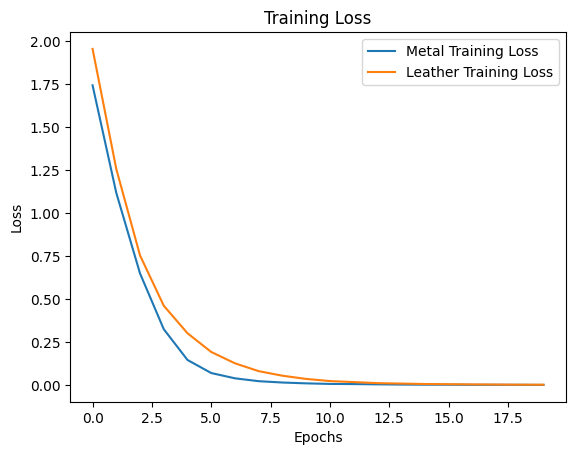

In [16]:
# Plot Loss Curve
loss_metal_array = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in loss_metal_list]
loss_leather_array = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in loss_leather_list]
plt.figure()
plt.plot(loss_metal_array, label="Metal Training Loss")
plt.plot(loss_leather_array, label="Leather Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend(loc='upper right')
plt.show()

Calculate & Plot ROC curve

Metal-nut origin ROC-AUC score: 0.9208211143695014


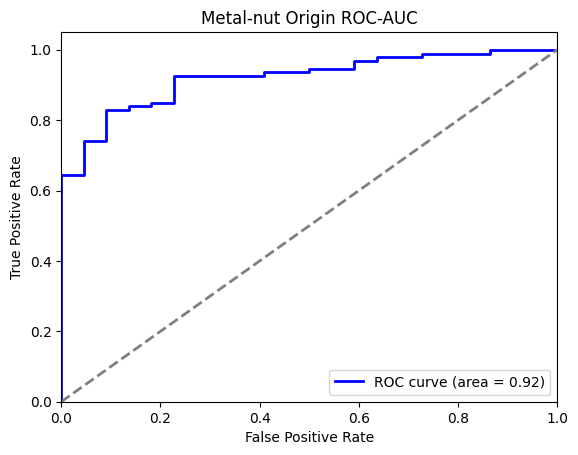

Leather origin ROC-AUC score: 0.9972826086956521


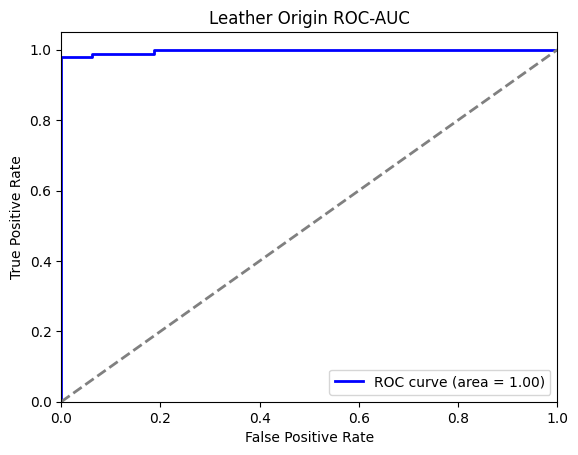

In [17]:
# Testing
result = test(encoder, simplenet_metal_origin, dataset_test_metal, use_layers, batch_size=16)
fpr, tpr, roc_auc_metal_origin = compute_roc_auc(result['total_gt_image'], result['total_scores_image'])
print("Metal-nut origin ROC-AUC score:", roc_auc_metal_origin)
plot_roc_auc(fpr, tpr, roc_auc_metal_origin, "Metal-nut Origin")

result = test(encoder, simplenet_leather_origin, dataset_test_leather, use_layers, batch_size=16)
fpr, tpr, roc_auc_leather_origin = compute_roc_auc(result['total_gt_image'], result['total_scores_image'])
print("Leather origin ROC-AUC score:", roc_auc_leather_origin)
plot_roc_auc(fpr, tpr, roc_auc_leather_origin, "Leather Origin")

#### Simple Net with different discriminator (1)

In [18]:
simplenet_metal_1 = Simplenet(in_channel=1536, model_type=1).cuda()
opt_adaptor_metal_1 = torch.optim.AdamW(simplenet_metal_1.adaptor.parameters(), lr=adaptor_lr)
opt_discriminator_metal_1 = torch.optim.Adam(simplenet_metal_1.discriminator.parameters(), lr=discriminator_lr, weight_decay=1e-5)

simplenet_leather_1 = Simplenet(in_channel=1536, model_type=1).cuda()
opt_adaptor_leather_1 = torch.optim.AdamW(simplenet_leather_1.adaptor.parameters(), lr=adaptor_lr)
opt_discriminator_leather_1 = torch.optim.Adam(simplenet_leather_1.discriminator.parameters(), lr=discriminator_lr, weight_decay=1e-5)

In [19]:
# Training
for epoch in tqdm(range(epochs)):
    loss_metal = train_one_epoch(encoder, simplenet_metal_1, opt_adaptor_metal_1, opt_discriminator_metal_1, dataset_train_metal, use_layers, batch_size)
    loss_leather = train_one_epoch(encoder, simplenet_leather_1, opt_adaptor_leather_1, opt_discriminator_leather_1, dataset_train_leather, use_layers, batch_size)
    print(f"Epoch {epoch + 1}")
    print(f"Metal loss: {loss_metal}")
    print(f"Leather loss: {loss_leather}\n")

  5%|▌         | 1/20 [00:01<00:33,  1.74s/it]

Epoch 1
Metal loss: 1.9224450588226318
Leather loss: 1.748234748840332



 10%|█         | 2/20 [00:03<00:30,  1.69s/it]

Epoch 2
Metal loss: 1.5292925834655762
Leather loss: 1.4949545860290527



 15%|█▌        | 3/20 [00:05<00:28,  1.70s/it]

Epoch 3
Metal loss: 1.183013916015625
Leather loss: 1.2700186967849731



 20%|██        | 4/20 [00:06<00:26,  1.67s/it]

Epoch 4
Metal loss: 0.9025040864944458
Leather loss: 1.0523974895477295



 25%|██▌       | 5/20 [00:08<00:25,  1.67s/it]

Epoch 5
Metal loss: 0.6925188302993774
Leather loss: 0.8669646978378296



 30%|███       | 6/20 [00:10<00:23,  1.68s/it]

Epoch 6
Metal loss: 0.5471466779708862
Leather loss: 0.6835764646530151



 35%|███▌      | 7/20 [00:11<00:21,  1.65s/it]

Epoch 7
Metal loss: 0.44922247529029846
Leather loss: 0.515180766582489



 40%|████      | 8/20 [00:13<00:19,  1.64s/it]

Epoch 8
Metal loss: 0.37492895126342773
Leather loss: 0.37128257751464844



 45%|████▌     | 9/20 [00:14<00:17,  1.62s/it]

Epoch 9
Metal loss: 0.31471431255340576
Leather loss: 0.2517411708831787



 50%|█████     | 10/20 [00:16<00:16,  1.62s/it]

Epoch 10
Metal loss: 0.2709219455718994
Leather loss: 0.1659315824508667



 55%|█████▌    | 11/20 [00:18<00:14,  1.62s/it]

Epoch 11
Metal loss: 0.2299061119556427
Leather loss: 0.10976780951023102



 60%|██████    | 12/20 [00:19<00:12,  1.62s/it]

Epoch 12
Metal loss: 0.19195517897605896
Leather loss: 0.07413769513368607



 65%|██████▌   | 13/20 [00:21<00:11,  1.61s/it]

Epoch 13
Metal loss: 0.16317211091518402
Leather loss: 0.056048087775707245



 70%|███████   | 14/20 [00:22<00:09,  1.61s/it]

Epoch 14
Metal loss: 0.13817931711673737
Leather loss: 0.042801376432180405



 75%|███████▌  | 15/20 [00:24<00:08,  1.61s/it]

Epoch 15
Metal loss: 0.11557218432426453
Leather loss: 0.034218087792396545



 80%|████████  | 16/20 [00:26<00:06,  1.61s/it]

Epoch 16
Metal loss: 0.09547212719917297
Leather loss: 0.02793017216026783



 85%|████████▌ | 17/20 [00:27<00:04,  1.64s/it]

Epoch 17
Metal loss: 0.08141116052865982
Leather loss: 0.022268015891313553



 90%|█████████ | 18/20 [00:29<00:03,  1.67s/it]

Epoch 18
Metal loss: 0.06762122362852097
Leather loss: 0.01857183501124382



 95%|█████████▌| 19/20 [00:31<00:01,  1.69s/it]

Epoch 19
Metal loss: 0.05764589458703995
Leather loss: 0.015780743211507797



100%|██████████| 20/20 [00:33<00:00,  1.65s/it]

Epoch 20
Metal loss: 0.047448113560676575
Leather loss: 0.012300020083785057



Metal-nut with simplenet_1 ROC-AUC score: 0.9711632453567937


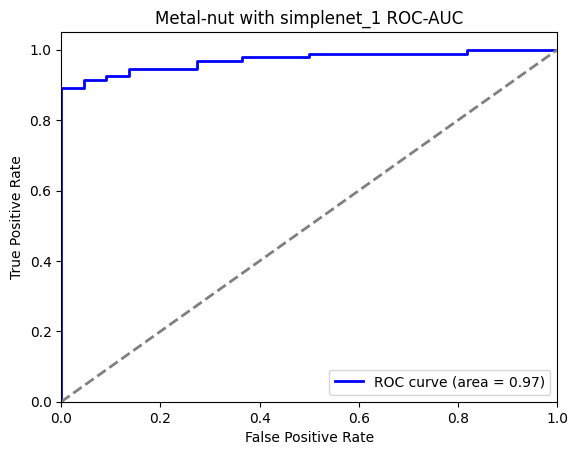

Leather with simplenet_1 ROC-AUC score: 0.9996603260869565


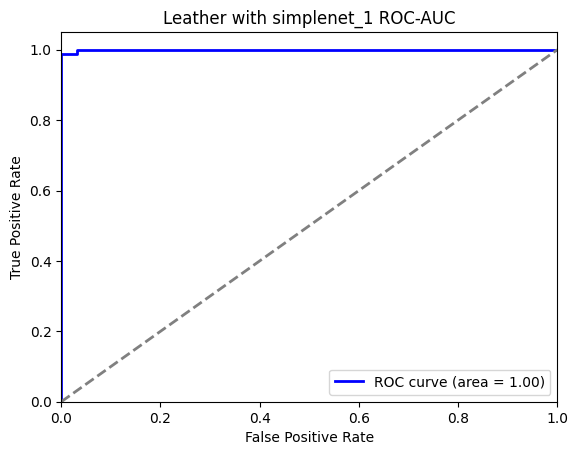

In [20]:
result = test(encoder, simplenet_metal_1, dataset_test_metal, use_layers, batch_size=16)
fpr, tpr, roc_auc_metal_1 = compute_roc_auc(result['total_gt_image'], result['total_scores_image'])
print("Metal-nut with simplenet_1 ROC-AUC score:", roc_auc_metal_1)
plot_roc_auc(fpr, tpr, roc_auc_metal_1, "Metal-nut with simplenet_1")

result = test(encoder, simplenet_leather_1, dataset_test_leather, use_layers, batch_size=16)
fpr, tpr, roc_auc_leather_1 = compute_roc_auc(result['total_gt_image'], result['total_scores_image'])
print("Leather with simplenet_1 ROC-AUC score:", roc_auc_leather_1)
plot_roc_auc(fpr, tpr, roc_auc_leather_1, "Leather with simplenet_1")

#### Simple Net with different discriminator (2)

In [21]:
simplenet_metal_2 = Simplenet(in_channel=1536, model_type=2).cuda()
opt_adaptor_metal_2 = torch.optim.AdamW(simplenet_metal_2.adaptor.parameters(), lr=1e-3)
opt_discriminator_metal_2 = torch.optim.Adam(simplenet_metal_2.discriminator.parameters(), lr=2e-4, weight_decay=1e-5)

simplenet_leather_2 = Simplenet(in_channel=1536, model_type=2).cuda()
opt_adaptor_leather_2 = torch.optim.AdamW(simplenet_leather_2.adaptor.parameters(), lr=1e-3)
opt_discriminator_leather_2 = torch.optim.Adam(simplenet_leather_2.discriminator.parameters(), lr=2e-4, weight_decay=1e-5)

In [22]:
# Training
loss_list = []
for epoch in tqdm(range(epochs)):
    loss_metal = train_one_epoch(encoder, simplenet_metal_2, opt_adaptor_metal_2, opt_discriminator_metal_2, dataset_train_metal, use_layers, batch_size)
    loss_leather = train_one_epoch(encoder, simplenet_leather_2, opt_adaptor_leather_2, opt_discriminator_leather_2, dataset_train_leather, use_layers, batch_size)
    print(f"Epoch {epoch + 1}")
    print(f"Metal loss: {loss_metal}")
    print(f"Leather loss: {loss_leather}\n")

  5%|▌         | 1/20 [00:01<00:28,  1.48s/it]

Epoch 1
Metal loss: 1.9921932220458984
Leather loss: 1.9744986295700073



 10%|█         | 2/20 [00:02<00:26,  1.48s/it]

Epoch 2
Metal loss: 1.9311977624893188
Leather loss: 1.6811695098876953



 15%|█▌        | 3/20 [00:04<00:24,  1.46s/it]

Epoch 3
Metal loss: 1.754332423210144
Leather loss: 1.561866044998169



 20%|██        | 4/20 [00:05<00:23,  1.47s/it]

Epoch 4
Metal loss: 1.6254932880401611
Leather loss: 1.4943578243255615



 25%|██▌       | 5/20 [00:07<00:21,  1.46s/it]

Epoch 5
Metal loss: 1.5471335649490356
Leather loss: 1.4553897380828857



 30%|███       | 6/20 [00:08<00:20,  1.46s/it]

Epoch 6
Metal loss: 1.4914145469665527
Leather loss: 1.415809154510498



 35%|███▌      | 7/20 [00:10<00:18,  1.45s/it]

Epoch 7
Metal loss: 1.4388070106506348
Leather loss: 1.3890647888183594



 40%|████      | 8/20 [00:11<00:17,  1.46s/it]

Epoch 8
Metal loss: 1.4089272022247314
Leather loss: 1.3704818487167358



 45%|████▌     | 9/20 [00:13<00:16,  1.47s/it]

Epoch 9
Metal loss: 1.3750169277191162
Leather loss: 1.3493609428405762



 50%|█████     | 10/20 [00:14<00:14,  1.49s/it]

Epoch 10
Metal loss: 1.3503340482711792
Leather loss: 1.3361859321594238



 55%|█████▌    | 11/20 [00:16<00:13,  1.51s/it]

Epoch 11
Metal loss: 1.3291454315185547
Leather loss: 1.3192534446716309



 60%|██████    | 12/20 [00:17<00:11,  1.50s/it]

Epoch 12
Metal loss: 1.310868501663208
Leather loss: 1.3076316118240356



 65%|██████▌   | 13/20 [00:19<00:10,  1.48s/it]

Epoch 13
Metal loss: 1.2936081886291504
Leather loss: 1.296724796295166



 70%|███████   | 14/20 [00:20<00:08,  1.47s/it]

Epoch 14
Metal loss: 1.2803949117660522
Leather loss: 1.2840900421142578



 75%|███████▌  | 15/20 [00:22<00:07,  1.48s/it]

Epoch 15
Metal loss: 1.2660245895385742
Leather loss: 1.2744805812835693



 80%|████████  | 16/20 [00:23<00:05,  1.48s/it]

Epoch 16
Metal loss: 1.2547509670257568
Leather loss: 1.2646832466125488



 85%|████████▌ | 17/20 [00:25<00:04,  1.47s/it]

Epoch 17
Metal loss: 1.2425512075424194
Leather loss: 1.2544350624084473



 90%|█████████ | 18/20 [00:26<00:02,  1.47s/it]

Epoch 18
Metal loss: 1.2338643074035645
Leather loss: 1.2465097904205322



 95%|█████████▌| 19/20 [00:28<00:01,  1.48s/it]

Epoch 19
Metal loss: 1.2237882614135742
Leather loss: 1.2391352653503418



100%|██████████| 20/20 [00:29<00:00,  1.48s/it]

Epoch 20
Metal loss: 1.216039776802063
Leather loss: 1.230207920074463



Metal-nut with simplenet_2 ROC-AUC score: 0.9173998044965788


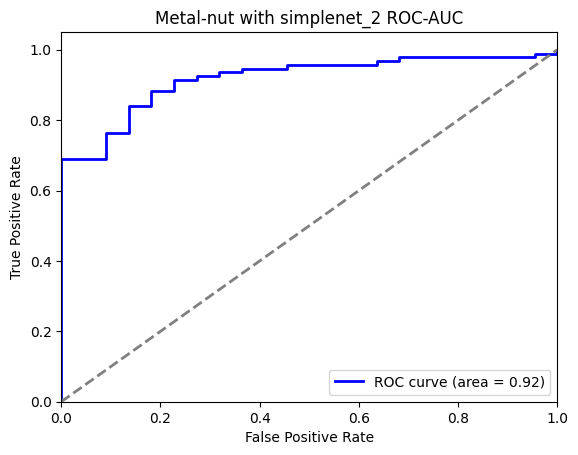

Leather with simplenet_2 ROC-AUC score: 0.9989809782608696


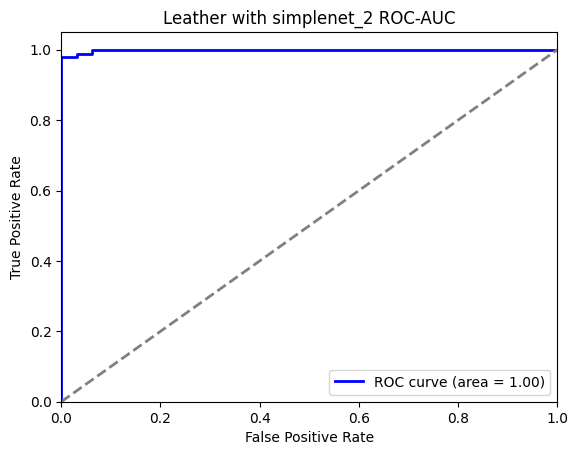

In [23]:
# Testing
result = test(encoder, simplenet_metal_2, dataset_test_metal, use_layers, batch_size=16)
fpr, tpr, roc_auc_metal_2 = compute_roc_auc(result['total_gt_image'], result['total_scores_image'])
print("Metal-nut with simplenet_2 ROC-AUC score:", roc_auc_metal_2)
plot_roc_auc(fpr, tpr, roc_auc_metal_2, "Metal-nut with simplenet_2")

result = test(encoder, simplenet_leather_2, dataset_test_leather, use_layers, batch_size=16)
fpr, tpr, roc_auc_leather_2 = compute_roc_auc(result['total_gt_image'], result['total_scores_image'])
print("Leather with simplenet_2 ROC-AUC score:", roc_auc_leather_2)
plot_roc_auc(fpr, tpr, roc_auc_leather_2, "Leather with simplenet_2")

# 15.Plot Parameters-ROC Figure (TODO Q5)


## TODO Q5
* Try different number of parameters in Adaptor/Discriminator, record the performance.
* Plot the figure with `X-axis=Number of SimpleNet Params`, `Y-axis=AUROC Performance`
* Mark the original SimpleNet as `black point`.
* Mark your models with different number of parameters as `blue points`.


In [24]:
# Use the following code to measure your model parameters
num_params_metal_origin = sum(p.numel() for p in simplenet_metal_origin.parameters())
num_params_leather_origin = sum(p.numel() for p in simplenet_leather_origin.parameters())
num_params_metal_1 = sum(p.numel() for p in simplenet_metal_1.parameters())
num_params_leather_1 = sum(p.numel() for p in simplenet_leather_1.parameters())
num_params_metal_2 = sum(p.numel() for p in simplenet_metal_2.parameters())
num_params_leather_2 = sum(p.numel() for p in simplenet_leather_2.parameters())

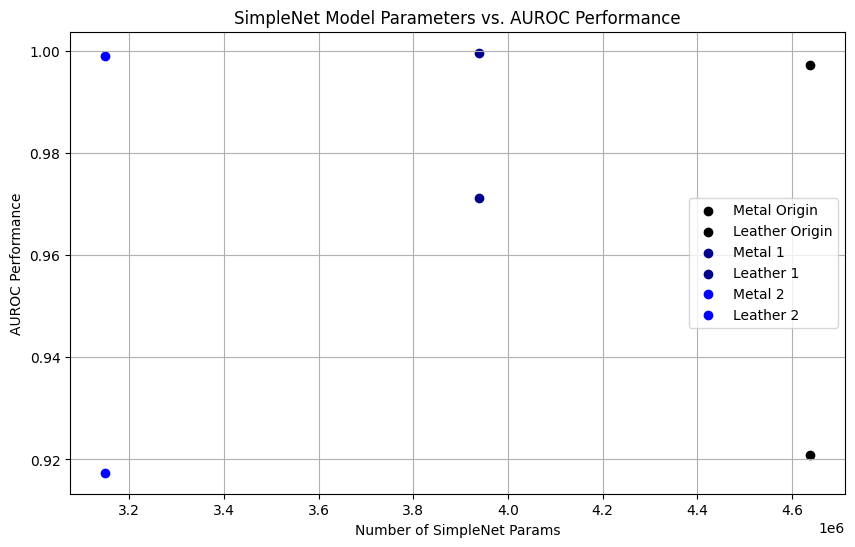

In [25]:
num_params = {
    'Metal Origin': num_params_metal_origin,
    'Leather Origin': num_params_leather_origin,
    'Metal 1': num_params_metal_1,
    'Leather 1': num_params_leather_1,
    'Metal 2': num_params_metal_2,
    'Leather 2': num_params_leather_2
}

roc_aucs = {
    'Metal Origin': roc_auc_metal_origin,
    'Leather Origin': roc_auc_leather_origin,
    'Metal 1': roc_auc_metal_1,
    'Leather 1': roc_auc_leather_1,
    'Metal 2': roc_auc_metal_2,
    'Leather 2': roc_auc_leather_2
}

plt.figure(figsize=(10, 6))
for label, params in num_params.items():
    auroc = roc_aucs[label]
    if "Origin" in label:
        plt.scatter(params, auroc, color='black', label=label)
    elif "1" in label:
        plt.scatter(params, auroc, color='darkblue', label=label)  
    elif "2" in label:
        plt.scatter(params, auroc, color='blue', label=label)

plt.title('SimpleNet Model Parameters vs. AUROC Performance')
plt.xlabel('Number of SimpleNet Params')
plt.ylabel('AUROC Performance')
plt.legend()
plt.grid(True)
plt.show()

# 15.Show Testing Results (Input & GT mask & anomaly map) (TODO Q6)

## TODO Q6
In this section, you need to choose a threshold for both class to produce a mask from anomaly map, a pixel with a score higher than the threshold is considered as anomaly region. Threshold should be a number between 0 and 1.

Random choose one inference mask for each class and output results.

(Testing Input / Ground Truth Mask / Predict Mask)

In [26]:
def test_one_epoch(encoder, simplenet, dataset, use_layers):
    result = dict()
    for x, y, mask in DataLoader(dataset, batch_size=1):
        if(y == 0): continue # skip good
        result['input_image'] = x.cpu().detach().numpy()
        result['total_gt_pixel'] = mask.cpu().detach().numpy()
        
        # generate score per pixel
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,use_layers)
        size = features.size()
        scores, true_feats = simplenet.predict(features)
        anomaly_score_map = rearrange(scores,'(b h w) 1 -> b 1 h w',b=size[0],h=size[3],w=size[2])
        anomaly_score_map = F.interpolate(anomaly_score_map,
                                        size=(x.size()[2],x.size()[3]),
                                        mode="bilinear",
                                        align_corners=False)
        result['total_scores_pixel'] = anomaly_score_map.cpu().detach().numpy()
        
        return result

In [27]:
def plot_results(test_input, gt_mask, anomaly_map, threshold=0.5):  
    test_input = np.transpose(test_input.squeeze(), (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    test_input = test_input * std + mean  
    test_input = np.clip(test_input, 0, 1)
    
    gt_mask = gt_mask.squeeze()
    anomaly_map = anomaly_map.squeeze()

    predict_mask = anomaly_map > threshold
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(test_input)
    ax[0].set_title('Testing Input')
    ax[0].axis('off')

    ax[1].imshow(gt_mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    ax[2].imshow(predict_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')

    plt.show()

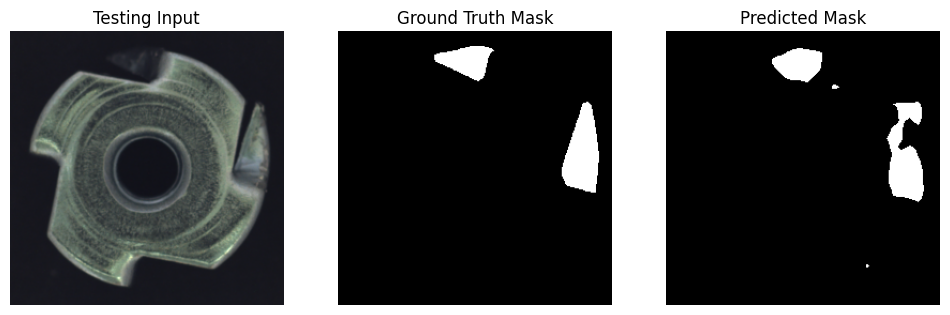

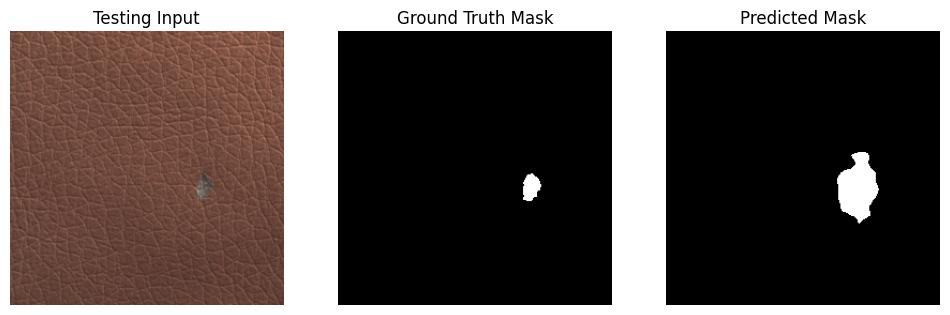

In [41]:
metal_threshold = 0.6
leather_threshold = 0.9

result = test_one_epoch(encoder, simplenet_metal_2, dataset_test_metal, use_layers)
test_input, gt_mask, anomaly_map = result['input_image'], result['total_gt_pixel'], result['total_scores_pixel']
plot_results(test_input, gt_mask, anomaly_map, metal_threshold)

result = test_one_epoch(encoder, simplenet_leather_2, dataset_test_leather, use_layers)
test_input, gt_mask, anomaly_map = result['input_image'], result['total_gt_pixel'], result['total_scores_pixel']
plot_results(test_input, gt_mask, anomaly_map, leather_threshold)

# 16.Ablation Study (TODO Q7 / Q8)

## TODO Q7
In this section, you need to conduct experiment with and without using the `adaptor`, and record the performance respectively

In [28]:
class Simplenet_wo_adaptor(nn.Module):
    def __init__(self,in_channel, model_type=0):
        super(Simplenet_wo_adaptor,self).__init__()
        if(model_type == 0):
            self.discriminator = Discriminator(in_channel)
        elif(model_type == 1):
            self.discriminator = Discriminator_1(in_channel)
        elif(model_type == 2):
            self.discriminator = Discriminator_2(in_channel)

    def add_noise(self,true_feats):
        noise_idxs = torch.randint(0, 1, torch.Size([true_feats.shape[0]]))
        noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=1).cuda() # (N, K)
        noise = torch.stack([
            torch.normal(0, 0.05 * 1.1**(k), true_feats.shape)
            for k in range(1)], dim=1).cuda() # (N, K, C)
        noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
        return true_feats + noise

    def forward(self,x):
        true_feats = rearrange(x, 'b c h w -> (b h w) c')
        fake_feats = self.add_noise(true_feats)
        scores = self.discriminator(torch.cat([true_feats,fake_feats],dim=0))
        return scores

    def predict(self,x):
        true_feats = rearrange(x, 'b c h w -> (b h w) c')
        scores = self.discriminator(true_feats)
        return scores,true_feats

In [29]:
def train_one_epoch_wo_ada(encoder,simplenet,discriminator_optim,dataset,use_layers,batch_size):
    total_loss = 0
    for x,y,mask in DataLoader(dataset,batch_size=batch_size):
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,use_layers)
        scores = simplenet(features)
        true_scores = scores[:features.size()[0]*features.size()[2]*features.size()[3]]
        fake_scores = scores[features.size()[0]*features.size()[2]*features.size()[3]:]

        th = 0.5 # margin
        true_loss = torch.clip(true_scores + th, min=0)
        fake_loss = torch.clip(-fake_scores + th, min=0)

        loss = true_loss.mean() + fake_loss.mean()
        total_loss += loss

        # clear gradient
        discriminator_optim.zero_grad()

        # calculate new gradient
        loss.backward()

        # update parameters
        discriminator_optim.step()
    return total_loss

In [30]:
# Create SimpleNet and optimizer for both classes
simplenet_metal_origin_wo_ada = Simplenet_wo_adaptor(in_channel=1536, model_type=0).cuda()
opt_discriminator_metal_origin_wo_ada = torch.optim.Adam(simplenet_metal_origin_wo_ada.discriminator.parameters(), lr=discriminator_lr, weight_decay=1e-5)

simplenet_leather_origin_wo_ada = Simplenet_wo_adaptor(in_channel=1536, model_type=0).cuda()
opt_discriminator_leather_origin_wo_ada = torch.optim.Adam(simplenet_leather_origin_wo_ada.discriminator.parameters(), lr=discriminator_lr, weight_decay=1e-5)

In [31]:
# Training
loss_metal_list = []
loss_leather_list = []
for epoch in tqdm(range(epochs)):
    loss_metal = train_one_epoch_wo_ada(encoder, simplenet_metal_origin_wo_ada, opt_discriminator_metal_origin_wo_ada, dataset_train_metal, use_layers, batch_size)
    loss_leather = train_one_epoch_wo_ada(encoder, simplenet_leather_origin_wo_ada, opt_discriminator_leather_origin_wo_ada, dataset_train_leather, use_layers, batch_size)
    print(f"Epoch {epoch + 1}")
    print(f"Metal loss: {loss_metal}")
    print(f"Leather loss: {loss_leather}\n")
    loss_metal_list.append(loss_metal)
    loss_leather_list.append(loss_leather)

  5%|▌         | 1/20 [00:01<00:29,  1.56s/it]

Epoch 1
Metal loss: 2.0648512840270996
Leather loss: 1.9071013927459717



 10%|█         | 2/20 [00:03<00:28,  1.57s/it]

Epoch 2
Metal loss: 1.9563994407653809
Leather loss: 1.724871277809143



 15%|█▌        | 3/20 [00:04<00:26,  1.58s/it]

Epoch 3
Metal loss: 1.8687633275985718
Leather loss: 1.5455201864242554



 20%|██        | 4/20 [00:06<00:24,  1.54s/it]

Epoch 4
Metal loss: 1.7816641330718994
Leather loss: 1.3696693181991577



 25%|██▌       | 5/20 [00:07<00:23,  1.54s/it]

Epoch 5
Metal loss: 1.6971943378448486
Leather loss: 1.2108194828033447



 30%|███       | 6/20 [00:09<00:21,  1.53s/it]

Epoch 6
Metal loss: 1.6135733127593994
Leather loss: 1.0655548572540283



 35%|███▌      | 7/20 [00:10<00:19,  1.52s/it]

Epoch 7
Metal loss: 1.5346239805221558
Leather loss: 0.9234961271286011



 40%|████      | 8/20 [00:12<00:18,  1.52s/it]

Epoch 8
Metal loss: 1.4586158990859985
Leather loss: 0.7984529137611389



 45%|████▌     | 9/20 [00:13<00:16,  1.52s/it]

Epoch 9
Metal loss: 1.3836555480957031
Leather loss: 0.6897841691970825



 50%|█████     | 10/20 [00:15<00:15,  1.53s/it]

Epoch 10
Metal loss: 1.3058106899261475
Leather loss: 0.5978246927261353



 55%|█████▌    | 11/20 [00:16<00:13,  1.52s/it]

Epoch 11
Metal loss: 1.2365199327468872
Leather loss: 0.5082204937934875



 60%|██████    | 12/20 [00:18<00:12,  1.52s/it]

Epoch 12
Metal loss: 1.1713835000991821
Leather loss: 0.4375183582305908



 65%|██████▌   | 13/20 [00:19<00:10,  1.52s/it]

Epoch 13
Metal loss: 1.1025639772415161
Leather loss: 0.3742639124393463



 70%|███████   | 14/20 [00:21<00:09,  1.51s/it]

Epoch 14
Metal loss: 1.0418901443481445
Leather loss: 0.3191467225551605



 75%|███████▌  | 15/20 [00:22<00:07,  1.51s/it]

Epoch 15
Metal loss: 0.9835125207901001
Leather loss: 0.2773516774177551



 80%|████████  | 16/20 [00:24<00:06,  1.53s/it]

Epoch 16
Metal loss: 0.9267076253890991
Leather loss: 0.24260087311267853



 85%|████████▌ | 17/20 [00:26<00:04,  1.55s/it]

Epoch 17
Metal loss: 0.8738829493522644
Leather loss: 0.20885014533996582



 90%|█████████ | 18/20 [00:27<00:03,  1.54s/it]

Epoch 18
Metal loss: 0.8285892009735107
Leather loss: 0.18260428309440613



 95%|█████████▌| 19/20 [00:29<00:01,  1.54s/it]

Epoch 19
Metal loss: 0.7749496698379517
Leather loss: 0.16221576929092407



100%|██████████| 20/20 [00:30<00:00,  1.54s/it]

Epoch 20
Metal loss: 0.7344626188278198
Leather loss: 0.1433488130569458



Metal-nut with simplenet_origin without adaptor ROC-AUC score: 0.8357771260997068


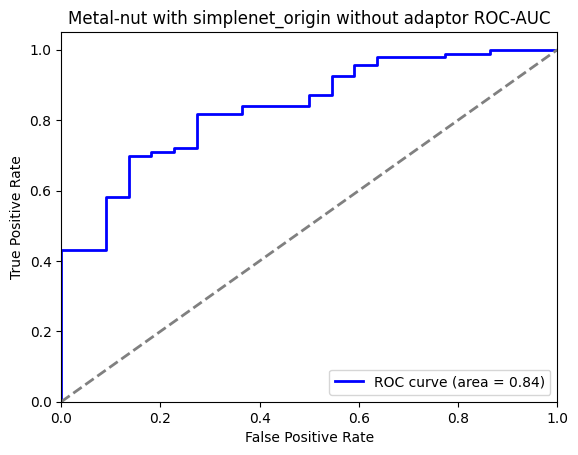

Leather with simplenet_origin without adaptor ROC-AUC score: 0.9996603260869565


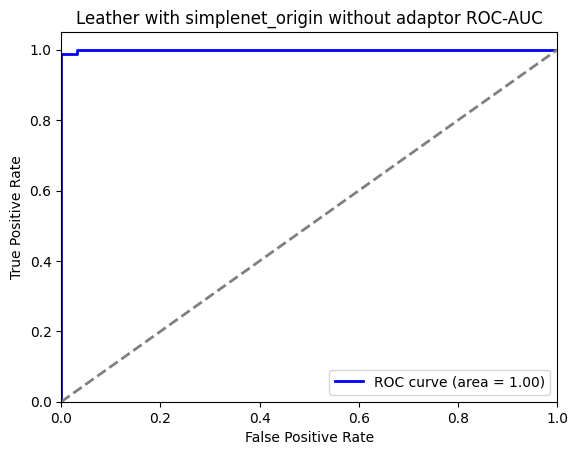

In [32]:
# Testing
result = test(encoder, simplenet_metal_origin_wo_ada, dataset_test_metal, use_layers, batch_size=16)
fpr, tpr, roc_auc_metal_origin_wo_ada = compute_roc_auc(result['total_gt_image'], result['total_scores_image'])
print("Metal-nut with simplenet_origin without adaptor ROC-AUC score:", roc_auc_metal_origin_wo_ada)
plot_roc_auc(fpr, tpr, roc_auc_metal_origin_wo_ada, "Metal-nut with simplenet_origin without adaptor")

result = test(encoder, simplenet_leather_origin_wo_ada, dataset_test_leather, use_layers, batch_size=16)
fpr, tpr, roc_auc_leather_origin_wo_ada = compute_roc_auc(result['total_gt_image'], result['total_scores_image'])
print("Leather with simplenet_origin without adaptor ROC-AUC score:", roc_auc_leather_origin_wo_ada)
plot_roc_auc(fpr, tpr, roc_auc_leather_origin_wo_ada, "Leather with simplenet_origin without adaptor")

In [42]:
print("Simplenet in metal", roc_auc_metal_origin)
print("Simplenet in leather", roc_auc_leather_origin)
print("Simplenet without adaptor in metal", roc_auc_metal_origin_wo_ada)
print("Simplenet without adaptor in leather", roc_auc_leather_origin_wo_ada)

Simplenet in metal 0.9208211143695014
Simplenet in leather 0.9972826086956521
Simplenet without adaptor in metal 0.8357771260997068
Simplenet without adaptor in leather 0.9996603260869565


## TODO Q8
In this section, you need to conduct experiment with `different scales of the Gaussian noises`. Find the best scale of the noise according to the AUROC performance.

In [43]:
#######################################
# define our model (simplenet)
class Simplenet_diff_noise(nn.Module):
    def __init__(self,in_channel, model_type=0, noise_scale=0.05):
        super(Simplenet_diff_noise,self).__init__()
        self.adaptor = Adaptor(in_channel,in_channel)
        self.noise_scale = noise_scale
        if(model_type == 0):
            self.discriminator = Discriminator(in_channel)
        elif(model_type == 1):
            self.discriminator = Discriminator_1(in_channel)
        elif(model_type == 2):
            self.discriminator = Discriminator_2(in_channel)

    def add_noise(self,true_feats):
        noise_idxs = torch.randint(0, 1, torch.Size([true_feats.shape[0]]))
        noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=1).cuda() # (N, K)
        noise = torch.stack([
            torch.normal(0, self.noise_scale * 1.1**(k), true_feats.shape)
            for k in range(1)], dim=1).cuda() # (N, K, C)
        noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
        return true_feats + noise

    def forward(self,x):
        true_feats = self.adaptor(x)
        fake_feats = self.add_noise(true_feats)
        scores = self.discriminator(torch.cat([true_feats,fake_feats],dim=0))
        return scores

    def predict(self,x):
        true_feats = self.adaptor(x)
        scores = self.discriminator(true_feats)
        return scores,true_feats

In [48]:
noise_scales = [0.01, 0.03, 0.07, 0.09]
max_mean_auc = 0
max_scale = 0

for scale in noise_scales:
    simplenet_metal_diff_scale = Simplenet_diff_noise(in_channel=1536, model_type=0, noise_scale=scale).cuda()
    opt_adaptor_metal_diff_scale = torch.optim.AdamW(simplenet_metal_diff_scale.adaptor.parameters(), lr=adaptor_lr)
    opt_discriminator_metal_diff_scale = torch.optim.Adam(simplenet_metal_diff_scale.discriminator.parameters(), lr=discriminator_lr, weight_decay=1e-5)
    
    simplenet_leather_diff_scale = Simplenet_diff_noise(in_channel=1536, model_type=0, noise_scale=scale).cuda()
    opt_adaptor_leather_diff_scale = torch.optim.AdamW(simplenet_leather_diff_scale.adaptor.parameters(), lr=adaptor_lr)
    opt_discriminator_leather_diff_scale = torch.optim.Adam(simplenet_leather_diff_scale.discriminator.parameters(), lr=discriminator_lr, weight_decay=1e-5)
    
    
    for epoch in tqdm(range(epochs)):
        loss_metal = train_one_epoch(encoder, simplenet_metal_diff_scale, opt_adaptor_metal_diff_scale, opt_discriminator_metal_diff_scale, dataset_train_metal, use_layers, batch_size)
        loss_leather = train_one_epoch(encoder, simplenet_leather_diff_scale, opt_adaptor_leather_diff_scale, opt_discriminator_leather_diff_scale, dataset_train_leather, use_layers, batch_size)
        # print(f"Epoch {epoch + 1}")
        # print(f"Metal loss: {loss_metal}")
        # print(f"Leather loss: {loss_leather}\n")
        
        
    result = test(encoder, simplenet_metal_diff_scale, dataset_test_metal, use_layers, batch_size=16)
    fpr, tpr, roc_auc_metal_diff_scale = compute_roc_auc(result['total_gt_image'], result['total_scores_image'])
    print(f"Metal-nut with noise scale {scale} ROC-AUC score:", roc_auc_metal_diff_scale)
    
    result = test(encoder, simplenet_leather_diff_scale, dataset_test_leather, use_layers, batch_size=16)
    fpr, tpr, roc_auc_leather_diff_scale = compute_roc_auc(result['total_gt_image'], result['total_scores_image'])
    print(f"Leather with noise scale {scale} ROC-AUC score:", roc_auc_leather_diff_scale)
    
    mean_auc = (roc_auc_metal_diff_scale + roc_auc_leather_diff_scale) / 2
    if(mean_auc > max_mean_auc):
        max_mean_auc = mean_auc
        max_scale = scale


100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Metal-nut with noise scale 0.01 ROC-AUC score: 0.8465298142717497
Leather with noise scale 0.01 ROC-AUC score: 0.9534646739130435


100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Metal-nut with noise scale 0.03 ROC-AUC score: 0.6520039100684262
Leather with noise scale 0.03 ROC-AUC score: 0.9976222826086957


100%|██████████| 20/20 [00:35<00:00,  1.75s/it]


Metal-nut with noise scale 0.07 ROC-AUC score: 0.9638318670576735
Leather with noise scale 0.07 ROC-AUC score: 0.9802989130434783


100%|██████████| 20/20 [00:32<00:00,  1.64s/it]


Metal-nut with noise scale 0.09 ROC-AUC score: 0.8812316715542522
Leather with noise scale 0.09 ROC-AUC score: 1.0


In [52]:
print("Simplenet origin mean ROC-AUC score", (roc_auc_metal_origin + roc_auc_leather_origin) / 2)
print(f"Simplenet origin with noise scale {max_scale} mean ROC-AUC score {max_mean_auc}")

Simplenet origin mean ROC-AUC score 0.9590518615325767
Simplenet origin with noise scale 0.07 mean ROC-AUC score 0.9720653900505759


# 17.Report (TODO Q9)

Write your observations on the two classes, for example:</br>
Based on the observation, which class is more difficult and why?

- 根據不同的訓練過程可以看出，leather的表現都比metal來的好上一些，以肉眼去分辨異常時，確實是metal的瑕疵比較不容易發現，雖然模型的feature reperesnetation與人眼所關注的點不同，但是我認為表現是合理的。
- 而且在不同的實驗上，metal的表現浮動比較大，有從0.85到0.97的區間，而leather的表現則是穩定在0.95以上，我認為原因同上，在做feature transform時，比較不好抓到異常的特徵
- 另外，在訓練上，我有將few shot的數量變多才可以train出超過roc-auc 0.8的模型